<a href="https://colab.research.google.com/github/brhwang0411/work_dept/blob/main/(WM)_Technical_Analysis_%EB%B3%B4%EC%9C%A0%EC%B0%A8%ED%8A%B8_(end_date_%EC%88%98%EC%A0%95).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 240627 상무님 코드 변경_v2

  0. 사용법
    * 3번째 코드 부분 user input 입력
      * is_long_only
        * True = long-only 전략으로 수익률 계산
        * False = long-short 전략으로 수익률 계산
      * enter_exit_type
        * Open: 시그널 발생 시점 기준 익일 시초가에 진입/출
        * Close: 시그널 발생 시점 기준 당일 종가에 진입/출


  1. 구현 사항
    * python ta package에서 지원하는 indicator 기반 long-only / long-short 전략 수익률 계산
    * OHLS 데이터 입수: yahoo finance (yfinance package)
    * 사용되는 indicator 종류 및 옵션 (최대한 Bloomberg 초기 세팅과 일치)
      * ADX는 bloomberg 비교 지표를 찾지 못함

| 지표	 | 옵션	 |
| :--: | :--: |
| SMA	 | 20D	 |
| MACD	 | fast 12D, slow 26D, signal 9D	 |
| RSI	 | 14D, 30 long + 70 exit or short	 |
| Bollinger Band	 | 20D, 2 stdev	 |
| Parabolic	 | 	step 0.02, max 0.2 |
| Stochastic	 | 	20D, 30 long + 70 exit or short |
| ADX	 | threshold 25	 |
| CCI	 | 	13D |



  2. 결과 차이 (윈도우: 2023/6/24 ~ 2024/6/21)

* Long only

| 지표	 | Bloomberg	 | 	 | 수정 코드	 | 	 |
| :--: | :--: | :--: | :--: | :--: |
| 	 | signal	출현 | 누적수익률	 | signal 출현	 | 누적수익률	 |
| MA	 | 12	 | 6.33%	 | 10	 | 7.44%	 |
| RSI	 | 2	 | 19.77%	 | 2	 | 19.77%	 |
| Bollinger Band	 | 4	 | 19.51%	 | 4	 | 21.68%	 |
| Parabolic	 | 	11 | 14.55%	 | 11	 | 	9.67% |
| Stochastic	 | 	6 | 9.41%	 | 5	 | 8.40% |
| MACD	 | 	10 | 5.08%	 | 9	 | 6.14% |
| CCI	 | 	8 | 10.56%	 | 7	 | 9.83% |
| ADX	 | 	- | 	- | 2	 | 4.57% |

* Long-short

| 지표	 | Bloomberg	 | 	 | 수정 코드	 | 	 |
| :--: | :--: | :--: | :--: | :--: |
| 	 | signal	출현 | 누적수익률	 | signal 출현	 | 누적수익률	 |
| MA	 | 	23 | 4.88%	 | 	20 | 6.31%	 |
| RSI	 | 3 | 25.72%	 | 	3 | 26.81%	 |
| Bollinger Band	 | 	8 | 	31.63% | 8 | 32.87% |
| Parabolic	 | 21	 | 	21.03% | 24	 | 	9.75%  |
| Stochastic	 | 11	 | 	10.97% | 11	 | 10.04% |
| MACD	 | 19	 | 2.67%	 | 17	 | 2.93% |
| CCI	 | 	16 | 	14.42% | 15	 | 12.53% |
| ADX	 | -	 | -	 | 5 | 0.04% |



  3. 결과 차이 원인
    * indicator window 차이
      * 해당 코드는 입력한 window의 데이터를 바탕으로 indicator 산출
        * 코드 결과에선 window 초반 indicator 값이 없을 수 있음
        * bloomberg와 유사한 값이 나오기까지 시차 발생
        * yahoo finance download: include start date + exclude end date
      * Bloomberg BTST는 각 indicator가 start date부터 존재할 수 있도록 더 과거의 데이터를 같이 불러와서 사용
    * parabolic SAR
      * 산식 자체의 추가적인 비교 필요: 같은 window를 사용하여도 pivot이 아예 달라짐


In [ ]:
# @title
!pip install -q ta
# !pip install -q pykrx

In [ ]:
# @title
import numpy as np
import pandas as pd
import yfinance as yf
import ta
from ta import add_all_ta_features
from datetime import datetime, timedelta

import time
import matplotlib.pyplot as plt

# from pykrx import stock as pkstock

In [ ]:
## User input
ticker = '^KS11'            # Yahoo Finance 티커
ticker = 'TSLA'            # Yahoo Finance 티커

start_date = '2021-06-24'   # window 시작일 (포함)
end_date = "2024-06-24"     # window 종료일 (포함, 단 미국 시장의 휴일인 경우에는 제외될 것임)

end_date = (datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')

is_long_only = True         # True - long only / False - long/short
enter_exit_type = "Open"    # Open - 시그널 발생 익일 시초가에 포지션 진출/입, Close - 시그널 발생 당일 종가에 포지션 진출/입

[*********************100%%**********************]  1 of 1 completed



Total Return for Each Strategy
Buy and Hold	-0.19429
Moving Average Crossover	0.76381
RSI Strategy	-0.02294
MACD Strategy	1.10962
Bollinger Bands Strategy	-0.08801
Parabolic SAR Strategy	0.88272
Stochastic Oscillator Strategy	-0.69508
ADX Strategy	0.72022
CCI Strategy	-0.26637

Sharpe Ratios for Each Strategy:
Buy and Hold: 0.17
Moving Average Crossover: 0.68
RSI Strategy: 0.20
MACD Strategy: 0.81
Bollinger Bands Strategy: 0.16
Parabolic SAR Strategy: 0.72
Stochastic Oscillator Strategy: -0.61
ADX Strategy: 0.75
CCI Strategy: -0.00

The most superior strategy based on the Sharpe Ratio is: MACD Strategy


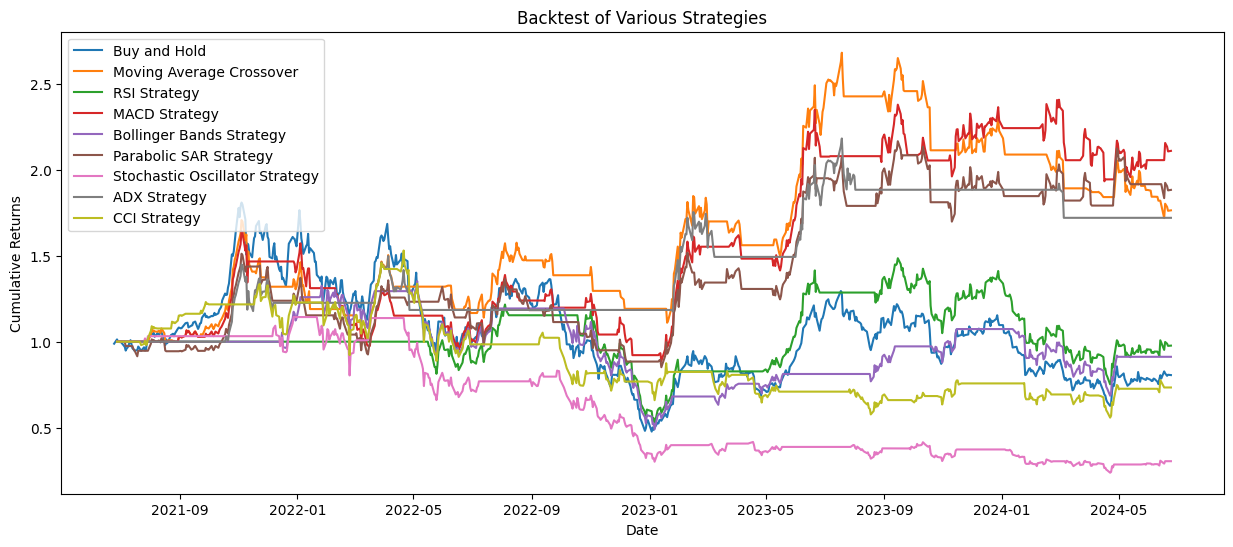

In [ ]:
# @title
# Load your historical data into a DataFrame
data = yf.download(ticker, start=start_date, end=end_date)

# Ensure these keys match your column names defined in the 'name' in 'data'
# If a new strategy comes into, then one should add it to the dict below
strategies = {
    'Buy and Hold': {'name': 'Buy_Hold_Returns'},
    'Moving Average Crossover': {'strg': 'SMA', 'name': 'SMA_Cumulative_Return'},
    'RSI Strategy': {'strg': 'RSI', 'name': 'RSI_Cumulative_Return'},
    'MACD Strategy': {'strg': 'MACD', 'name': 'MACD_Cumulative_Return'},
    'Bollinger Bands Strategy': {'strg': 'BB', 'name': 'BB_Cumulative_Return'},
    'Parabolic SAR Strategy': {'strg': 'SAR', 'name': 'SAR_Cumulative_Return'},
    'Stochastic Oscillator Strategy': {'strg': 'Stoch', 'name': 'Stoch_Cumulative_Return'},
    'ADX Strategy': {'strg': 'ADX', 'name': 'ADX_Cumulative_Return'},
    'CCI Strategy': {'strg': 'CCI', 'name': 'CCI_Cumulative_Return'}
}

# Buy and Hold Strategy
data['Buy_Hold_Returns'] = (1+data['Close'].pct_change()).cumprod()

## Define Calculating Function for Strategy Return
def cal_strategy_return(df, long_signal, short_signal, long_only=True, position_timing='Open'):
    temp = df[[long_signal, short_signal]].copy()
    temp['Signal'] = 0
    temp.loc[temp[long_signal], 'Signal'] = 1
    temp.loc[temp[short_signal], 'Signal'] = -1
    temp['Signal'] = temp['Signal'].replace(0, method='ffill').fillna(0)
    if long_only:
        temp.loc[temp['Signal'] == -1, 'Signal'] = 0

    if position_timing == 'Open':
      temp['Strategy_Return'] = df['Open'].pct_change() * temp['Signal'].shift(2) ## 익일 시초가 입출: pct_change 자체가 shift(1) 기능이 있어서 signal은 shift(2)로 매칭시켜야 적합
      temp.at[temp.index[-1], 'Strategy_Return'] = (1 + temp.at[temp.index[-1], 'Strategy_Return']) * \
                                                    ((df['Close'].iloc[-1] / df['Open'].iloc[-1] - 1) * temp['Signal'].iloc[-1] + 1) - 1## Blbg: close price까지 return 반영
    elif position_timing == 'Close':
      temp['Strategy_Return'] = df['Close'].pct_change() * temp['Signal'].shift(1) ## 당일 종가 입출
    else:
      temp['Strategy_Return'] = 0 ## no proper result without proper options

    return temp['Signal'], temp['Strategy_Return']


# Moving Average Crossover Strategy
ma_window = 20
data['SMA'] = ta.trend.sma_indicator(data['Close'], window=ma_window)
data['SMA_long_crossover'] = (data['Close'] > data['SMA']) & (data['Close'].shift(1) < data['SMA'].shift(1))
data['SMA_short_crossover'] = (data['Close'] < data['SMA']) & (data['Close'].shift(1) > data['SMA'].shift(1))


# RSI Strategy
long_threshold, short_threshold = 30, 70
data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()
data['RSI_long_crossover'] = (data['RSI'] > long_threshold) & (data['RSI'].shift(1) < long_threshold)
data['RSI_short_crossover'] = (data['RSI'] < short_threshold) & (data['RSI'].shift(1) > short_threshold)


# MACD Crossover Strategy
macd = ta.trend.MACD(data['Close'])
data['MACD'] = macd.macd()
data['MACD_diff'] = macd.macd_diff()
data['MACD_sig'] = macd.macd_signal()
data['MACD_long_crossover'] = (data['MACD'] > data['MACD_sig']) & (data['MACD'].shift(1) < data['MACD_sig'].shift(1))
data['MACD_short_crossover'] = (data['MACD'] < data['MACD_sig']) & (data['MACD'].shift(1) > data['MACD_sig'].shift(1))


# Commodity Channel Index (CCI) Strategy
long_threshold, short_threshold = -100, 100
data['CCI'] = ta.trend.CCIIndicator(data['High'], data['Low'], data['Close'], window=13).cci()
data['CCI_long_crossover'] = (data['CCI'] > long_threshold) & (data['CCI'].shift(1) < long_threshold)
data['CCI_short_crossover'] = (data['CCI'] < short_threshold) & (data['CCI'].shift(1) > short_threshold)


# Bollinger Bands Strategy
bollinger = ta.volatility.BollingerBands(data['Close'])
data['BB_hband'] = bollinger.bollinger_hband()
data['BB_lband'] = bollinger.bollinger_lband()
data['BB_long_crossover'] = (data['Close'] < data['BB_lband']) & (data['Close'].shift(1) > data['BB_lband'].shift(1))
data['BB_short_crossover'] = (data['Close'] > data['BB_hband']) & (data['Close'].shift(1) < data['BB_hband'].shift(1))


# Parabolic SAR Strategy
data['SAR'] = ta.trend.PSARIndicator(data['High'], data['Low'], data['Close']).psar()
data['SAR_long_crossover']  = (data['Close'] > data['SAR'])
data['SAR_short_crossover']  = (data['Close'] < data['SAR'])


# Stochastic Oscillator Strategy
long_threshold, short_threshold = 30, 70
window = 20 # bloomberg default
data['Stoch'] = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], window=window).stoch()
data['Stoch_long_crossover'] = (data['Stoch'] < long_threshold) & (data['Stoch'].shift(1) > long_threshold)
data['Stoch_short_crossover'] = (data['Stoch'] > short_threshold) & (data['Stoch'].shift(1) < short_threshold)


# ADX (Average Directional Movement) Strategy: cannot find a comparison to Blbg BTST
adx = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'])
adx_threshold = 25
data['ADX'] = adx.adx()
data['ADX_+DI'] = adx.adx_pos()
data['ADX_-DI'] = adx.adx_neg()
data['ADX_long_crossover'] = (data['ADX'] > adx_threshold) & (data['ADX_+DI'] > data['ADX_-DI'])
data['ADX_short_crossover'] = (data['ADX'] < adx_threshold) & (data['ADX_+DI'] < data['ADX_-DI'])


for values in strategies.values():
  if 'strg' in values.keys():
    strg = values['strg']
    data[f'{strg}_Signal'], data[f'{strg}_Strategy_Return'] = cal_strategy_return(data, f'{strg}_long_crossover', f'{strg}_short_crossover', long_only=is_long_only)
    data[f'{strg}_Cumulative_Return'] = (1 + data[f'{strg}_Strategy_Return']).cumprod()


data.to_excel("data.xlsx")

# Plotting the cumulative returns of each strategy
plt.figure(figsize=(15, 6))

print('\nTotal Return for Each Strategy')
for k, i in strategies.items():
  print(f"{k}\t{data.tail()[i['name']].tolist()[-1]-1:.5f}")

# Set the risk-free rate
risk_free_rate = 0.0

# Calculating Sharpe Ratio for each strategy
sharpe_ratios = {}
for strategy_name, v in strategies.items():
    # Calculate the strategy's excess returns
    excess_returns = data[v['name']].pct_change() - risk_free_rate

    # Calculate annualized Sharpe Ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    sharpe_ratios[strategy_name] = sharpe_ratio

best_strategy = max(sharpe_ratios, key=sharpe_ratios.get)

print("\nSharpe Ratios for Each Strategy:")
for strategy, sharpe_ratio in sharpe_ratios.items():
    print(f"{strategy}: {sharpe_ratio:.2f}")

print(f"\nThe most superior strategy based on the Sharpe Ratio is: {best_strategy}")

for strategy_name, v in strategies.items():
    plt.plot(data[v['name']], label=strategy_name)

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest of Various Strategies')
plt.legend()
plt.show()

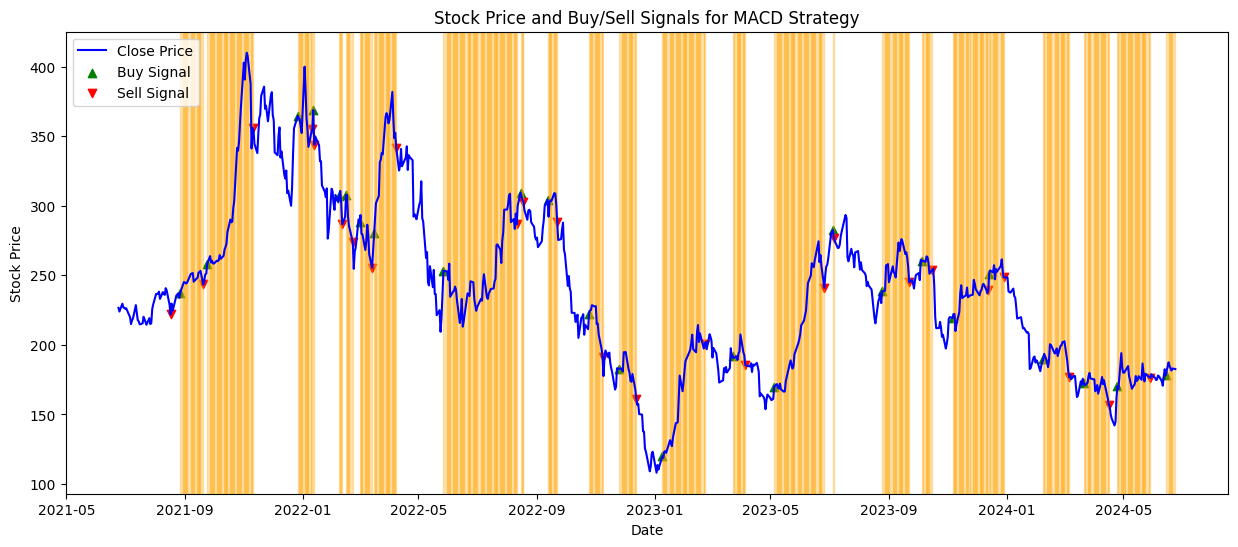

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the stock price with buy/sell signals for the best strategy
plt.figure(figsize=(15, 6))
plt.plot(data['Close'], label='Close Price', color='blue')

best_strategy_key = strategies[best_strategy]['strg']
buy_signals = data[data[f'{best_strategy_key}_long_crossover']].index
sell_signals = data[data[f'{best_strategy_key}_short_crossover']].index

# Plot buy and sell signals
plt.scatter(buy_signals, data.loc[buy_signals, 'Close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals, data.loc[sell_signals, 'Close'], marker='v', color='red', label='Sell Signal', alpha=1)

# Fill regions based on the signal
signal = data[f'{best_strategy_key}_Signal']

for i in range(len(signal) - 1):
    if signal[i] == 1:
        plt.axvspan(data.index[i], data.index[i + 1], color='orange', alpha=0.3)
    elif signal[i] == -1:
        plt.axvspan(data.index[i], data.index[i + 1], color='blue', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'Stock Price and Buy/Sell Signals for {best_strategy}')
plt.legend()
plt.show()
